In [1]:
import json
import sys
from pathlib import Path
from typing import Tuple

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import yaml
import bentoml
from PIL.Image import Image

from utils.seed import set_seed

2025-12-12 20:01:32.678173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_model(
    image_shape: Tuple[int, int, int],
    dropout_1: float,
    dense_size: int,
    regularization_l2_1: float,
    dropout_2: float,
    output_classes: int,
    regularization_l2_2: float,
) -> tf.keras.Model:
    """Transfer learning model using MobileNetV2 as base model"""

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=image_shape,
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = True

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_1),
        tf.keras.layers.Dense(dense_size, activation='mish', kernel_regularizer=regularizers.l2(regularization_l2_1)),
        tf.keras.layers.Dropout(dropout_2),
        tf.keras.layers.Dense(output_classes, kernel_regularizer=regularizers.l2(regularization_l2_2))
    ])

    return model

In [5]:
seed= 77
lr= 0.0001
epochs= 9
dropout_1= 0.3
dense_size= 128
regularization_l2_1= 0.001
dropout_2= 0.3
output_classes= 6
regularization_l2_2= 0.001

In [9]:
prepared_dataset_folder = Path('./../data/prepared')
model_folder = Path('./../model')

# Set seed for reproducibility
set_seed(seed)

# Load data
ds_train = tf.data.Dataset.load(str(prepared_dataset_folder / "train"))
ds_test = tf.data.Dataset.load(str(prepared_dataset_folder / "test"))

ds_hitl = tf.data.Dataset.load(str(prepared_dataset_folder / "hitl"))

# Combine original training data with HITL data
ds_train = ds_train.concatenate(ds_hitl)

labels = None
with open(prepared_dataset_folder / "labels.json") as f:
    labels = json.load(f)

In [21]:

image_shape = (256, 256, 3)
# Define the model
model = get_model(image_shape, 
                    dropout_1, 
                    dense_size, 
                    regularization_l2_1, 
                    dropout_2, 
                    output_classes, 
                    regularization_l2_2)

/tmp/ipykernel_3720/2450893178.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [22]:
model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [23]:

epochs=5
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
    callbacks=[lr_scheduler, early_stopping]
    )

Epoch 1/5
379/379 ━━━━━━━━━━━━━━━━━━━━ 143s 306ms/step - loss: 0.9542 - sparse_categorical_accuracy: 0.7468 - val_loss: 1.9349 - val_sparse_categorical_accuracy: 0.5669 - learning_rate: 1.0000e-04
Epoch 2/5
379/379 ━━━━━━━━━━━━━━━━━━━━ 115s 304ms/step - loss: 0.4765 - sparse_categorical_accuracy: 0.9187 - val_loss: 1.6687 - val_sparse_categorical_accuracy: 0.6392 - learning_rate: 1.0000e-04
Epoch 3/5
379/379 ━━━━━━━━━━━━━━━━━━━━ 120s 315ms/step - loss: 0.3150 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.8968 - val_sparse_categorical_accuracy: 0.8162 - learning_rate: 1.0000e-04
Epoch 4/5
379/379 ━━━━━━━━━━━━━━━━━━━━ 122s 321ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.7752 - val_sparse_categorical_accuracy: 0.8500 - learning_rate: 1.0000e-04
Epoch 5/5
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 363ms/step - loss: 0.2387 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.8494 - val_sparse_categorical_accuracy: 0.8424 - learning_rate: 1.0000e-04


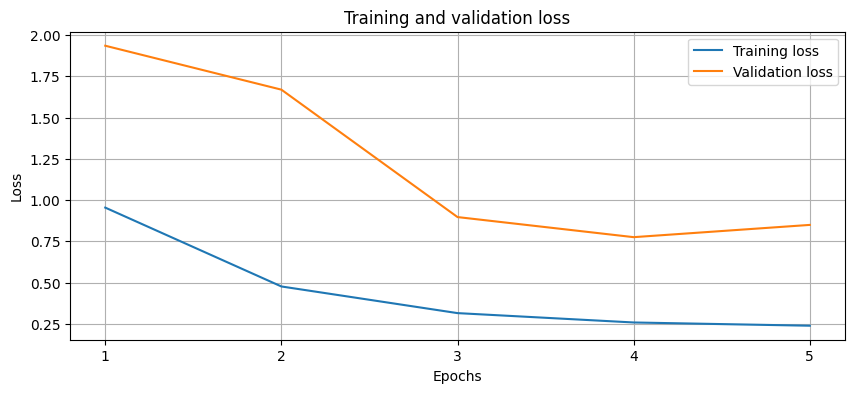

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

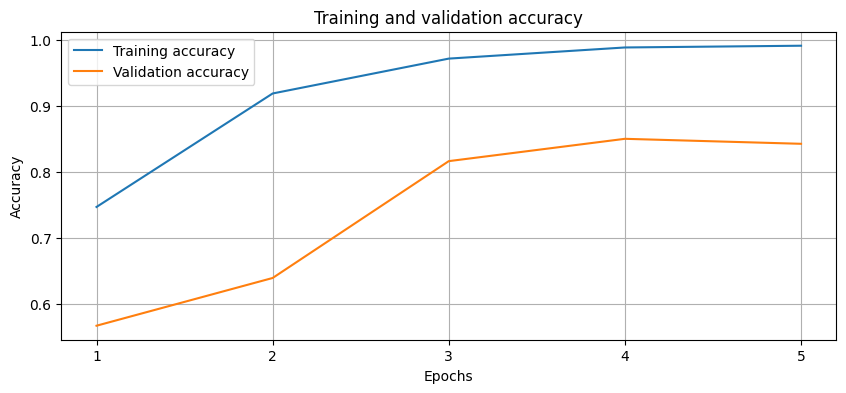

In [25]:
# Plot the training and validation sparse categorical accuracy
history = model.history.history
epochs = range(1, len(history["sparse_categorical_accuracy"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["sparse_categorical_accuracy"], label="Training accuracy")
plt.plot(epochs, history["val_sparse_categorical_accuracy"], label="Validation accuracy")
plt.xticks(epochs)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.7752 - sparse_categorical_accuracy: 0.8500
Validation loss: 0.78
Validation accuracy: 85.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-12-12 20:58:49.023582: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


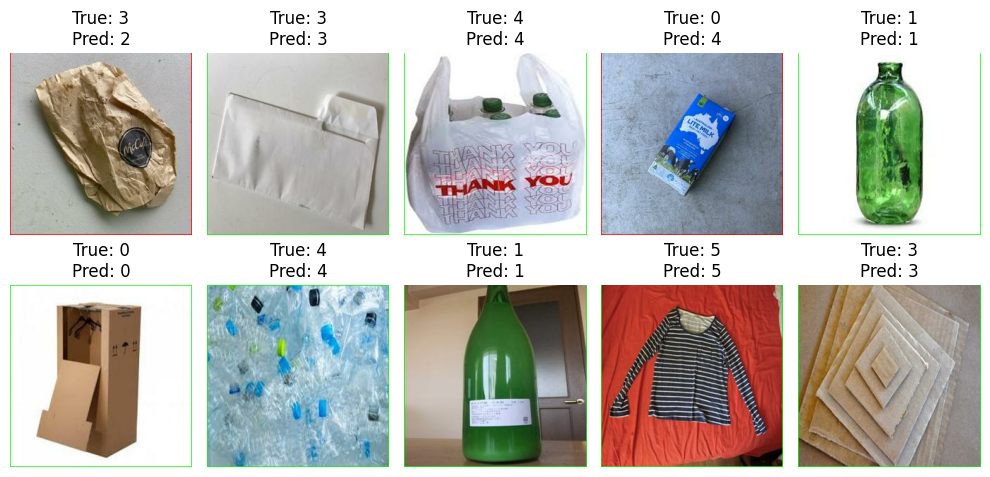

In [27]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


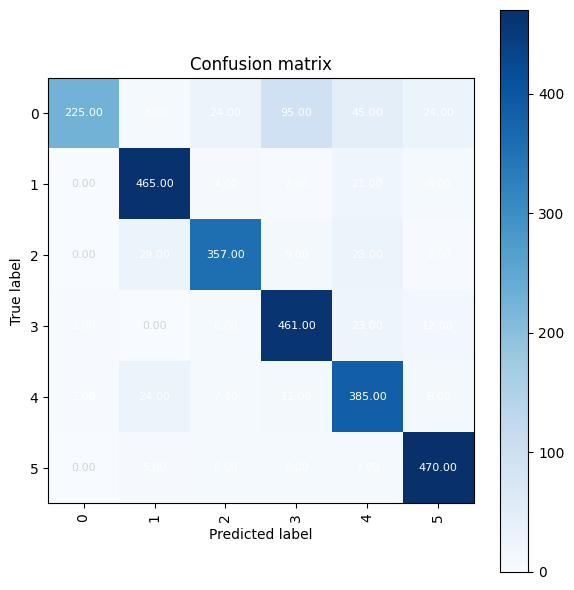

In [28]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

In [29]:
# Score accuracy, precision and f1-score of model on the test set

y_true = tf.concat([y for _, y in ds_test], axis=0).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

# Report scikit-learn classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=False)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.69       420
           1       0.88      0.93      0.90       498
           2       0.88      0.84      0.86       425
           3       0.79      0.91      0.85       505
           4       0.76      0.88      0.81       438
           5       0.90      0.95      0.93       494

    accuracy                           0.85      2780
   macro avg       0.86      0.84      0.84      2780
weighted avg       0.86      0.85      0.84      2780



# Evaluation dataset indépendant

In [36]:
import pandas as pd

labels_test2 = pd.read_csv('./../data/labels_raw2_test.csv')['choice'].tolist()

In [37]:
def transform_labels_to_int(label : str) -> int:
    match label:
        case 'cardboard':
            return 0
        case 'glass':
            return 1
        case 'metal':
            return 2
        case 'paper':
            return 3
        case 'plastic':
            return 4
        case 'trash':
            return 5
        
labels_test2 = [transform_labels_to_int(label) for label in labels_test2]
nom_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [38]:
ds_test2 = tf.keras.utils.image_dataset_from_directory(
    './../data/raw2/test/images',
    image_size=(256, 256),
    batch_size=32,
    labels=labels_test2,
    label_mode='int',
    shuffle=False
)

Found 1042 files belonging to 3 classes.


In [43]:
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_test2 = ds_test2.map(lambda x, y: (normalization_layer(x), y))

In [45]:
preds2 = model.predict(ds_test2)
y_true2 = tf.concat([y for _, y in ds_test2], axis=0).numpy()
y_pred2 = tf.argmax(preds2, axis=1).numpy()

from sklearn.metrics import classification_report
report2 = classification_report(y_true2, y_pred2, output_dict=False)
print("Classification Report on independent test dataset:")
print(report2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
Classification Report on independent test dataset:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.96      0.79      0.87       170
           3       0.96      0.89      0.93       523
           4       0.95      0.89      0.92       349
           5       0.00      0.00      0.00         0

    accuracy                           0.87      1042
   macro avg       0.48      0.43      0.45      1042
weighted avg       0.96      0.87      0.91      1042



/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cris/mlops/MLOps-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 